# Time Series Analysis for Corn Future Price using ARIMA

In [1]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb
from statsmodels.tsa.arima_model import ARIMA

# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.keys import Keys
# from bs4 import BeautifulSoup
# import time

import investpy

In [2]:
# http://download.macrotrends.net/assets/php/stock_data_export.php?t=MSFT
    
# #--| Setup
# options = Options()
# #options.add_argument("--headless")
# browser = webdriver.Chrome(executable_path=r'C:\cmder\bin\chromedriver.exe', options=options)
# #--| Parse or automation
# browser.get('https://www.macrotrends.net/2532/corn-prices-historical-chart-data?freq=A')
# time.sleep(3)
# soup = BeautifulSoup(browser.page_source, 'lxml')
# table = soup.select('#contentjqxgrid > div.jqx-grid-content.jqx-widget-content')
# #print(table)
 
# # First row test
# #revenue = soup.select('#row0jqxgrid')
# #print(revenue)
# first_val = soup.select('#row0jqxgrid > div:nth-child(3) > div')
# #print('-' * 20)
# print(first_val[0].text)

## Data Prep - Pulling stock data for each US Dollar Index, Corn, Gas, Ethanol Futures from YahooFinance API

In [3]:
#Extract data from YahooFinance
pd.core.common.is_list_like = pd.api.types.is_list_like
stocks = ['DX-Y.NYB', 'EH=F','ZC=F', 'NG=F']
# 'DXK18.NYB'
start = dt.datetime(2000,1,1)
end = dt.datetime.today()    
df = wb.DataReader(stocks, 'yahoo',start,end)["Adj Close"].sort_index()
# renaming the column names
df.columns.values[0] = "USD_Index"
df.columns.values[1] = "Ethanol_future"
df.columns.values[2] = "Corn_future"
df.columns.values[3] = "Natural_Gas_future"
# # Save the stock data a csv file
df.to_csv("../Resources/df.csv")
df.tail()

Symbols,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future
Date,,,,
2020-11-16,92.570000,1.44,416.25,2.697
2020-11-17,92.419998,1.42,420.25,2.692
2020-11-18,92.320000,1.42,425.75,2.712
2020-11-19,92.290001,1.39,422.50,2.592
2020-11-20,92.397003,NaN,428.00,2.665


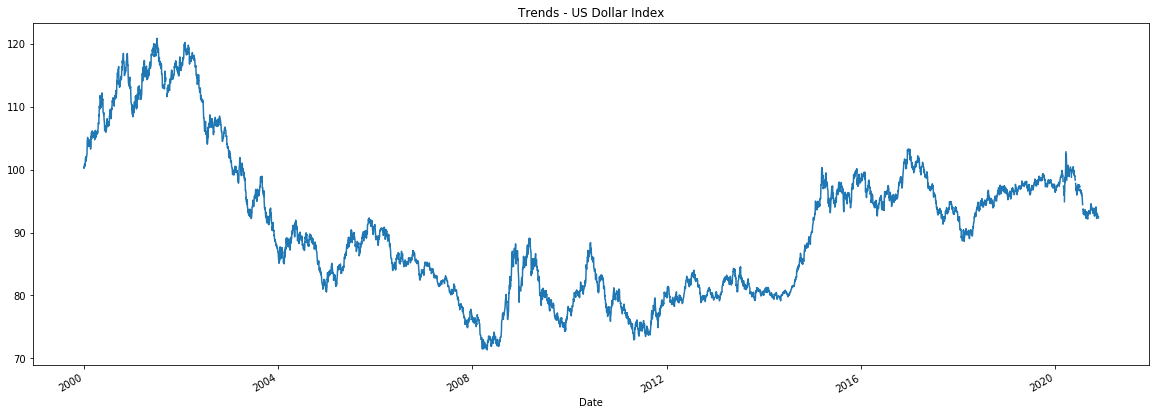

In [4]:
# Plotting and saving the trends.
df["USD_Index"].plot(title='Trends - US Dollar Index', figsize=(20,7))
plt.savefig("../Images/Trends_US_Index.png")

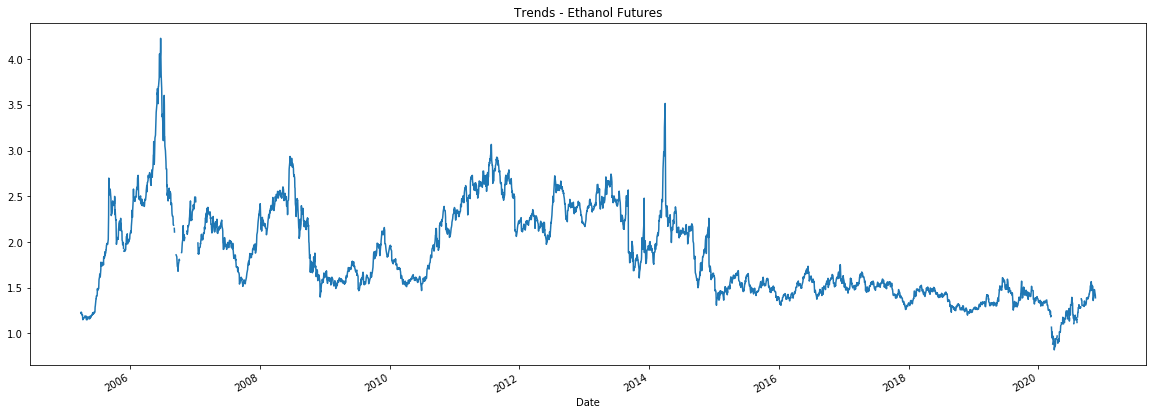

In [5]:
# Plotting and saving the trends.
df["Ethanol_future"].plot(title='Trends - Ethanol Futures', figsize=(20,7))
plt.savefig("../Images/Trends_Ethanol_Futures.png")

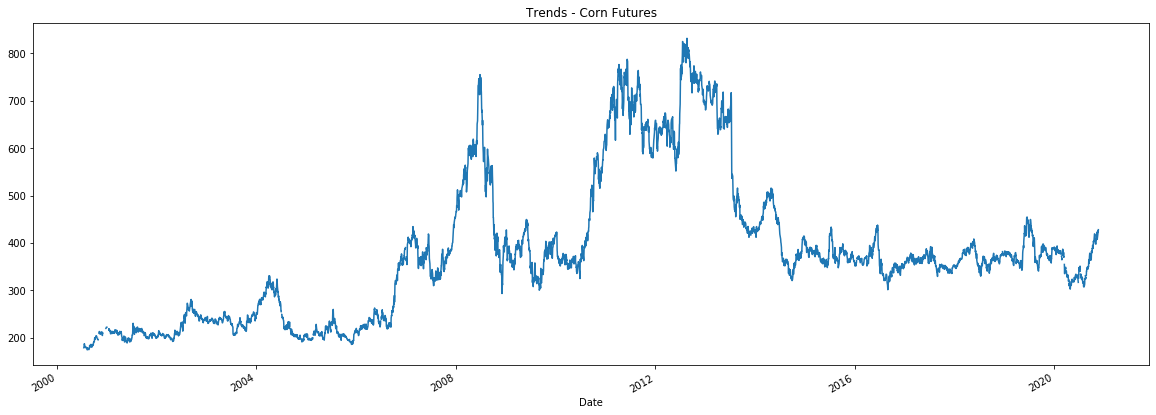

In [6]:
# Plotting and saving the trends.
df["Corn_future"].plot(title='Trends - Corn Futures', figsize=(20,7))
plt.savefig("../Images/Trends_Corn_Futures.png")

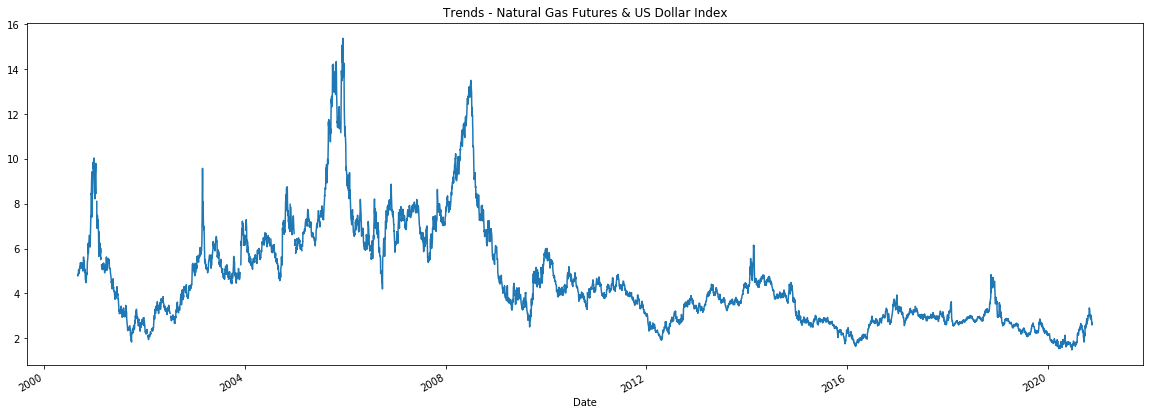

In [7]:
# Plotting and saving the trends.
df["Natural_Gas_future"].plot(title='Trends - Natural Gas Futures & US Dollar Index', figsize=(20,7))
plt.savefig("../Images/Trends_Natural_Gas_Futures.png")

In [8]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1':]
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
corn_act_prices.head()

,Corn_Price
Date,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300
2000-01-06,2.0375
2000-01-07,2.0700


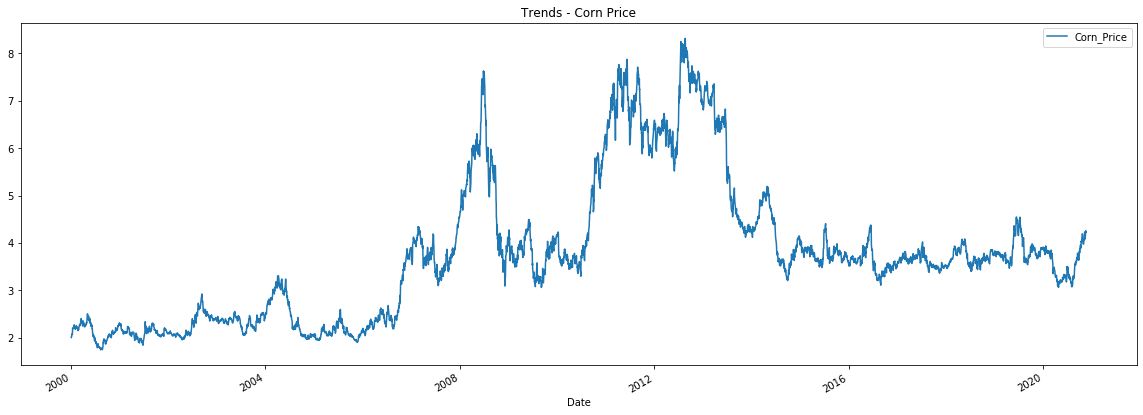

In [9]:
# Plotting and saving the Corn price trends.
corn_act_prices.plot(title='Trends - Corn Price', figsize=(20,7))
plt.savefig("../Images/Trends_Corn_Price.png")

In [10]:
# Read in corn actual price and sort by date
weather_data = pd.read_csv(Path("../Resources/corn_belt_weather.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
weather_data.index.names = ['Date']
weather_data.head(2)

,PRCP_Illinois,TMAX_Illinois,TMIN_Illinois,PRCP_Indiana,TMAX_Indiana,TMIN_Indiana,PRCP_Iowa,TMAX_Iowa,TMIN_Iowa,PRCP_Nebraska,TMAX_Nebraska,TMIN_Nebraska,PRCP_Ohio,TMAX_Ohio,TMIN_Ohio
Date,,,,,,,,,,,,,,,
2000-01-01,0.000000,7.78,-2.34,0.00,10.6375,-3.4125,0.000000,6.94,-4.16,0.0000,9.757143,-5.785714,0.0,9.1000,-5.7000
2000-01-02,0.166667,12.44,0.88,0.31,15.2125,1.3250,0.254545,5.50,-0.66,0.0375,6.312500,-7.425000,0.0,13.6125,-0.2875


In [11]:
# Calculating Averages
weather_data["avg_prcp"] = (weather_data["PRCP_Illinois"] + weather_data["PRCP_Indiana"] + weather_data["PRCP_Iowa"] +weather_data["PRCP_Nebraska"]+ weather_data["PRCP_Ohio"])/5
weather_data["avg_max"] = (weather_data["TMAX_Illinois"] + weather_data["TMAX_Indiana"] + weather_data["TMAX_Iowa"] +weather_data["TMAX_Nebraska"]+ weather_data["TMAX_Ohio"])/5
weather_data["avg_min"] = (weather_data["TMIN_Illinois"] + weather_data["TMIN_Indiana"] + weather_data["TMIN_Iowa"] +weather_data["TMIN_Nebraska"]+ weather_data["TMIN_Ohio"])/5
#Keeping only the averages precipitation, maximum and minimum temperatures of the 5 states in the USA
weather_data = weather_data[["avg_prcp", "avg_max", "avg_min"]]
weather_data.head()

,avg_prcp,avg_max,avg_min
Date,,,
2000-01-01,0.000000,8.842929,-4.279643
2000-01-02,0.153742,10.615500,-1.233500
2000-01-03,6.079909,10.354000,0.158500
2000-01-04,12.314167,5.425500,-6.184000
2000-01-05,0.314429,0.954000,-9.541786


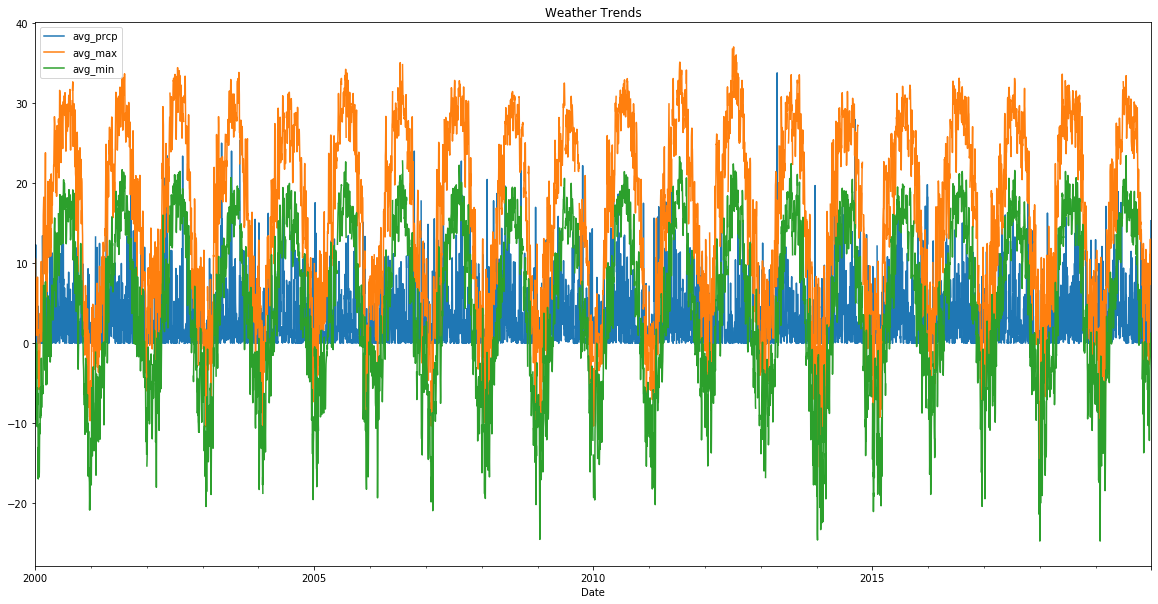

In [12]:
# Plotting and saving the Corn price trends.
weather_data.plot(title='Weather Trends', figsize=(20,10))
plt.savefig("../Images/Trends_weather.png")

In [13]:
# Merge data
## Combine 
combined_portfolios_df = pd.concat(
    [corn_act_prices, df, weather_data], axis="columns", join="inner"
)
combined_portfolios_df
combined_portfolios_df.tail()

,Corn_Price,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future,avg_prcp,avg_max,avg_min
Date,,,,,,,,
2019-12-23,3.8875,97.680000,1.388,388.75,2.214,0.0000,11.092857,-2.582619
2019-12-26,3.8850,97.589996,1.403,388.50,2.294,0.0000,13.022662,0.019210
2019-12-27,3.9000,96.919998,1.386,390.00,2.158,0.0525,10.674242,-0.881167
2019-12-30,3.8825,96.739998,1.382,388.25,2.186,NaN,NaN,NaN
2019-12-31,3.8775,96.389999,1.375,387.75,2.189,NaN,NaN,NaN


In [14]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
combined_portfolios_df.dtypes, combined_portfolios_df.count(), combined_portfolios_df.isnull().sum(), combined_portfolios_df.shape

(Corn_Price            float64
 USD_Index             float64
 Ethanol_future        float64
 Corn_future           float64
 Natural_Gas_future    float64
 avg_prcp              float64
 avg_max               float64
 avg_min               float64
 dtype: object,
 Corn_Price            5001
 USD_Index             4999
 Ethanol_future        3661
 Corn_future           4824
 Natural_Gas_future    4822
 avg_prcp              4792
 avg_max               4786
 avg_min               4785
 dtype: int64,
 Corn_Price               0
 USD_Index                2
 Ethanol_future        1340
 Corn_future            177
 Natural_Gas_future     179
 avg_prcp               209
 avg_max                215
 avg_min                216
 dtype: int64,
 (5001, 8))

In [15]:
# Drop nulls from combined DataFrame
combined_portfolios_df.dropna(inplace=True)

In [16]:
# Final data checks
combined_portfolios_df.isnull().sum(), combined_portfolios_df.shape, combined_portfolios_df.describe()

(Corn_Price            0
 USD_Index             0
 Ethanol_future        0
 Corn_future           0
 Natural_Gas_future    0
 avg_prcp              0
 avg_max               0
 avg_min               0
 dtype: int64,
 (3475, 8),
         Corn_Price    USD_Index  Ethanol_future  Corn_future  \
 count  3475.000000  3475.000000     3475.000000  3475.000000   
 mean      4.306828    86.420368        1.899365   429.870000   
 std       1.422524     8.066937        0.480979   144.158608   
 min       1.907500    71.330002        1.150000   186.250000   
 25%       3.565000    80.040001        1.505000   354.000000   
 50%       3.797500    84.639999        1.770000   377.750000   
 75%       4.956250    94.625000        2.270500   496.000000   
 max       8.312500   103.290001        4.230000   831.250000   
 
        Natural_Gas_future     avg_prcp      avg_max      avg_min  
 count         3475.000000  3475.000000  3475.000000  3475.000000  
 mean             4.554605     2.780263    16.7963

In [17]:
combined_portfolios_df.head()
# # Save the stock data a csv file
combined_portfolios_df.to_csv("../Resources/combined_portfolios_df.csv")

In [18]:
#Construct a correlation table
correlation_table = combined_portfolios_df.corr()
correlation_table

,Corn_Price,USD_Index,Ethanol_future,Corn_future,Natural_Gas_future,avg_prcp,avg_max,avg_min
Corn_Price,1.000000,-0.534182,0.527469,0.997730,-0.169994,0.004557,-0.016805,-0.032309
USD_Index,-0.534182,1.000000,-0.658860,-0.531781,-0.408545,-0.004811,-0.015477,-0.002103
Ethanol_future,0.527469,-0.658860,1.000000,0.529289,0.400634,0.001420,0.077587,0.061743
Corn_future,0.997730,-0.531781,0.529289,1.000000,-0.174040,0.006116,-0.009014,-0.024297
Natural_Gas_future,-0.169994,-0.408545,0.400634,-0.174040,1.000000,0.006667,-0.025428,-0.025750
avg_prcp,0.004557,-0.004811,0.001420,0.006116,0.006667,1.000000,0.192185,0.269149
avg_max,-0.016805,-0.015477,0.077587,-0.009014,-0.025428,0.192185,1.000000,0.976210
avg_min,-0.032309,-0.002103,0.061743,-0.024297,-0.025750,0.269149,0.976210,1.000000


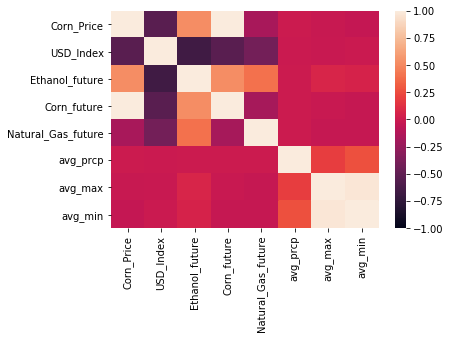

In [19]:
#correlation matrix using a heatmap
sns.heatmap(correlation_table, vmin=-1, vmax=1)

## ARIMA

### Creating Training and Validation Datasets

In [20]:
# Trim the datasets to have Training data (70%: 30% split)
corn_df_tr = combined_portfolios_df.loc['2005-03-28':'2015-08-31']
# Trim the datasets to have Validation data from 10 July 2020 - 30 Sep 2020 (70%: 30% split)
corn_df_val = combined_portfolios_df.loc['2015-09-1': :]

# Data Checks
corn_df_tr.tail(), corn_df_tr.shape, corn_df_val.head(), corn_df_val.shape

(            Corn_Price  USD_Index  Ethanol_future  Corn_future  \
 Date                                                             
 2015-08-24      3.6875  93.309998           1.443       368.75   
 2015-08-25      3.6550  94.529999           1.440       365.50   
 2015-08-26      3.6405  95.099998           1.415       361.75   
 2015-08-27      3.6825  95.610001           1.428       363.75   
 2015-08-28      3.7030  96.110001           1.443       363.25   
 
             Natural_Gas_future  avg_prcp    avg_max    avg_min  
 Date                                                            
 2015-08-24               2.650  1.723000  25.088333  10.719786  
 2015-08-25               2.685  0.000000  23.916786  10.323381  
 2015-08-26               2.693  0.000000  23.348881  11.329754  
 2015-08-27               2.638  0.021667  24.602095  11.867643  
 2015-08-28               2.715  3.731167  25.070071  12.938167  ,
 (2432, 8),
             Corn_Price  USD_Index  Ethanol_future  Co

## Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the closing price into a trend and noise.

In [21]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Corn Price" into two separate series:
ts_noise_corn, ts_trend_corn = sm.tsa.filters.hpfilter(corn_df_tr["Corn_Price"])

In [22]:
# Create dataframes of just the exchange rate price, and add columns for "noise" and "trend" series from above:
corn_df_tr["ts_noise_corn"] = ts_noise_corn
corn_df_tr["ts_trend_corn"] = ts_trend_corn

corn_df_tr.reset_index()

corn_df_hpf = corn_df_tr[["Corn_Price", "ts_noise_corn", "ts_trend_corn"]]
# Data Sample Checks
corn_df_hpf.tail()

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Corn_Price,ts_noise_corn,ts_trend_corn
Date,,,
2015-08-24,3.6875,0.046001,3.641499
2015-08-25,3.6550,0.021675,3.633325
2015-08-26,3.6405,0.015084,3.625416
2015-08-27,3.6825,0.064836,3.617664
2015-08-28,3.7030,0.093030,3.609970


In [23]:
# Data Checks
corn_df_hpf.dtypes

Corn_Price       float64
ts_noise_corn    float64
ts_trend_corn    float64
dtype: object

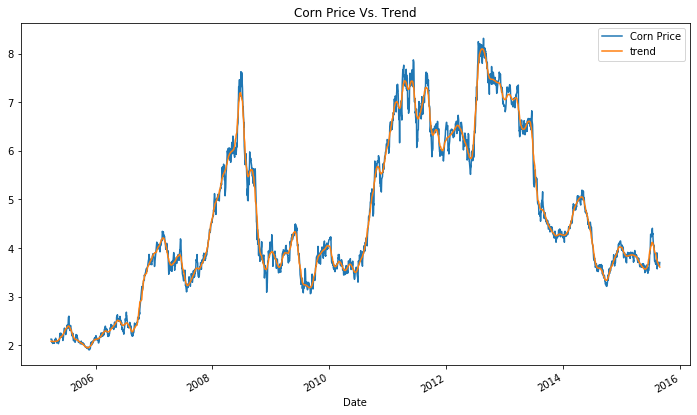

In [24]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_trend_corn.plot(label = 'trend', title='Corn Price Vs. Trend', figsize=(12,7),legend = True);

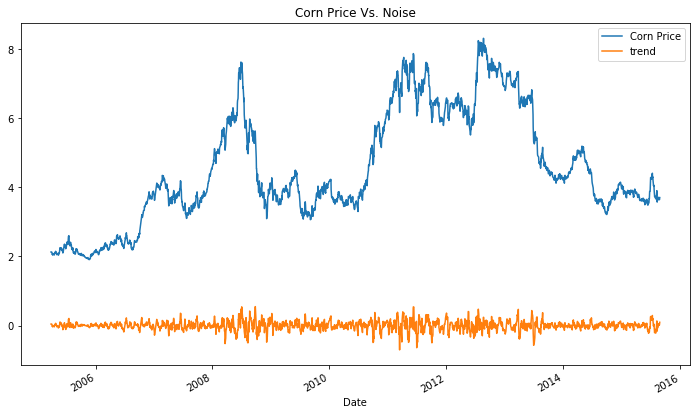

In [25]:
# Plot the Corn Price Close vs. the Trend 
corn_df_hpf["Corn_Price"].plot(label = 'Corn Price', figsize=(10,6),legend = True)
corn_df_hpf.ts_noise_corn.plot(label = 'trend', title='Corn Price Vs. Noise', figsize=(12,7),legend = True);

## Variable Selection for the ARIMA Model

Comparing Absolute Corn Price versus percent change metrics to conclude which variable is better fit for model development 

In [26]:
# Creating percent change of the Adj Close 
corn_returns = (corn_df_tr[['Corn_Price']].pct_change()).replace(-np.inf, np.nan).dropna()
corn_returns.tail()

,Corn_Price
Date,
2015-08-24,0.009582
2015-08-25,-0.008814
2015-08-26,-0.003967
2015-08-27,0.011537
2015-08-28,0.005567


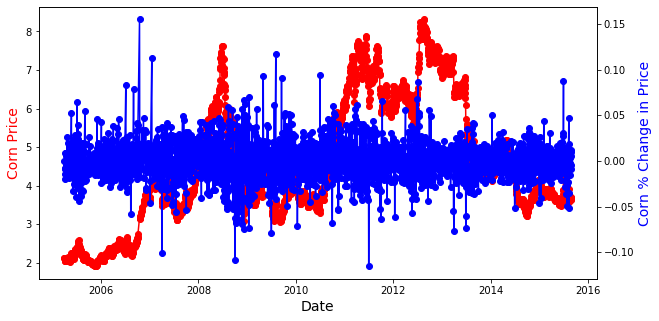

In [27]:
# Plotting the Absolute Corn price versus % change in the Corn price to determine which data should be used in
# modelling exercise

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize= (10,5))
# make a plot
ax.plot(corn_df_tr.index, corn_df_tr['Corn_Price'], color="red", marker="o")
# # set x-axis label
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Corn Price",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(corn_returns.index, corn_returns['Corn_Price'],color="blue",marker="o")
ax2.set_ylabel("Corn % Change in Price",color="blue",fontsize=14)
plt.show()

From the above graphs it is evident that % change in the corn prices is more stationary than the absolute corn price and hence, should be used in ARIMA modelling

## Autocorrelation & Partial Autocorrelation Analysis

Use the autocorrelation and partial autocorrelation data to get a sense of how many lags to use in the ARIMA models

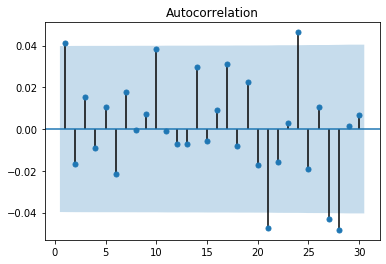

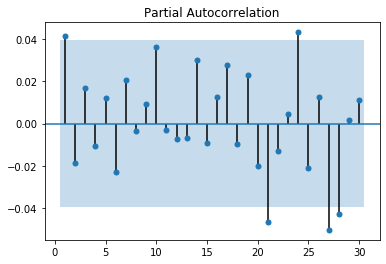

In [28]:
# Import ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(corn_returns['Corn_Price'], lags=30, zero=False)
plot_pacf(corn_returns['Corn_Price'], lags=30, zero=False);

ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Basically, how well the present value of the series is related to its past values. While, PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.

Both ACF and PACF can be used to identify the orders of AR and MA terms in the ARMA model.

From the above ACF plot we notice that 2-4 lags could potentialy useful while PACF is significant at the 4-5 lags are outside the default confidence interval of 95%. Hence, we will play with p and q accordingly to create the ARIMA models for each of the pharmaceutical stocks.

## Forecasting Corn Returns using an ARIMA Model

In [29]:
# Estimate ARIMA Model:
model = ARIMA(corn_returns['Corn_Price'], order=(2, 1,2))
# Fit the model
results = model.fit()
# save model
results.save("../Model_Results/Corn_ARIMA_PC_model.pkl")

from statsmodels.tsa.arima_model import ARIMAResults
# load model
loaded = ARIMAResults.load("../Model_Results/Corn_ARIMA_PC_model.pkl")
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Corn_Price   No. Observations:                 2430
Model:                 ARIMA(2, 1, 2)   Log Likelihood                5966.678
Method:                       css-mle   S.D. of innovations              0.021
Date:                Fri, 20 Nov 2020   AIC                         -11921.357
Time:                        19:36:34   BIC                         -11886.583
Sample:                             1   HQIC                        -11908.714
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -9.127e-07   6.24e-07     -1.462      0.144   -2.14e-06    3.11e-07
ar.L1.D.Corn_Price    -0.9548      0.020    -46.588      0.000      -0.995      -0.915
ar.L2.D.Corn_Price     0.0379      0.020      1.866      0.062      -0.002       0.078
ma.L1.D.Corn_Price    -0.0029      0.003     -0.897      0.370      -0.009       0.003
ma.L2.D.Corn_Price    -0.9971      0.003   -306.165      0.000      -1.003      -0.991
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0071           +0.0000j            1.0071            0.5000
AR.2           26.1957           +0.0000j           26.1957            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0029           +0.0000j            1.0029            0.5000
-----------------------------------------------------------------------------
"""

In [30]:
# #Getting the forecasted values of the adjusted closing price
corn_forecasted_values=np.array(1+ results.forecast(steps=1043)[0])
for i in range(1, len(corn_forecasted_values)):
    corn_forecasted_values[i] = corn_forecasted_values[i]*corn_forecasted_values[i-1]
corn_forecasted_values = corn_forecasted_values*combined_portfolios_df.loc['2015-08-28']['Corn_Price']
corn_forecasted_values

array([3.7021739 , 3.69897351, 3.69722278, ..., 1.12244285, 1.12062235,
       1.11880408])

## Validation of the Corn

In [31]:
# Getting the array of the actual adjusted closing prices for Corn stock
corn_actual_val = np.array(corn_df_val["Corn_Price"])
# Calculating the differnce between actual and forecasted values
abs_change = np.absolute(np.array(corn_actual_val) - np.array(corn_forecasted_values))
corn_avg_error = sum(abs_change)/ len(abs_change)
# Printing the average error term
print(corn_avg_error)

1.355249214281271


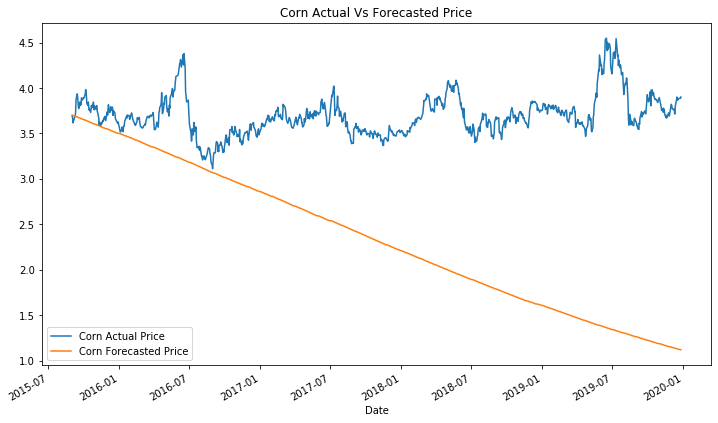

In [32]:
# Combining Date,Actual and Predicted Adj Closing price for Corn 
Corn_Comp1 = pd.DataFrame({'Date': corn_df_val.index.values, 'Corn_Actual_Price': corn_actual_val, 'Corn_Forecasted_Price': corn_forecasted_values}, columns=['Date', 'Corn_Actual_Price', 'Corn_Forecasted_Price'])
Corn_Comp= Corn_Comp1.set_index("Date")
# Plot the variation of model
Corn_Comp["Corn_Actual_Price"].plot(label = 'Corn Actual Price', figsize=(10,6),legend = True)
Corn_Comp["Corn_Forecasted_Price"].plot(label = 'Corn Forecasted Price', title='Corn Actual Vs Forecasted Price', figsize=(12,7),legend = True);
plt.savefig("../Images/TS_Corn_Actual_Forecasted.png")

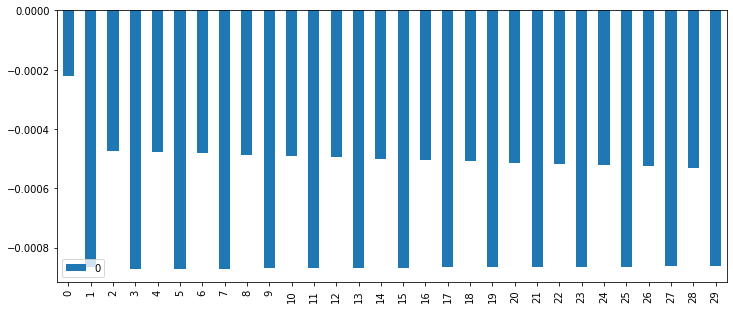

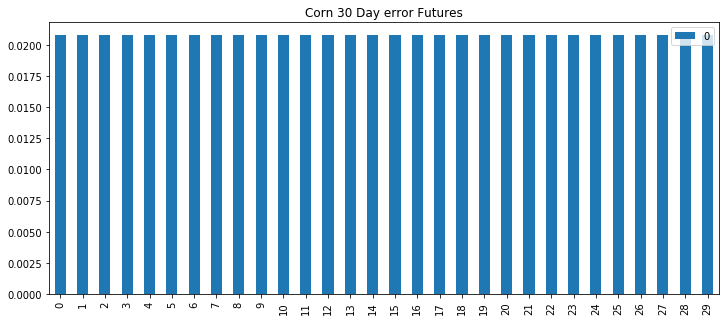

In [33]:
# Plot the 1 month of Closing Price Forecast
pd.DataFrame(results.forecast(steps=30)[0]).plot(kind='bar',figsize=(12,5),legend = True)
pd.DataFrame(results.forecast(steps=30)[1]).plot(kind='bar',title="Corn 30 Day error Futures",figsize=(12,5),legend = True);

## Extra Variables to be explored later - China Imports and Inflation Rates

In [34]:
# Read in China Yearly Imports and sort by year
china_imports_df = pd.read_csv(Path("../Resources/china_imports.csv")).sort_index()
# delete last row
china_imports_df = china_imports_df[:-1]
china_imports_df.head()

,Year,Imports,Unit of Measure
0,2000,89.0,(1000 MT)
1,2001,39.0,(1000 MT)
2,2002,29.0,(1000 MT)
3,2003,2.0,(1000 MT)
4,2004,2.0,(1000 MT)


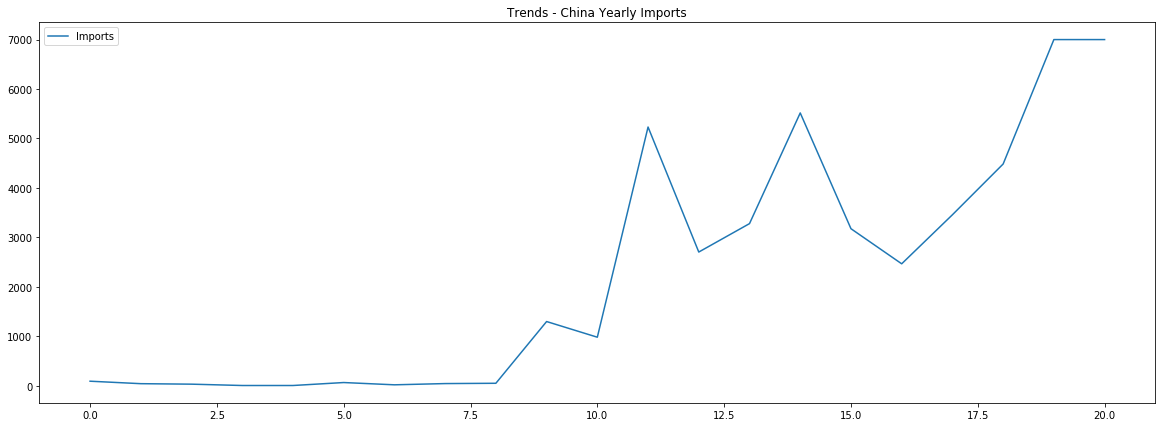

In [35]:
# Plotting the China Yearly Imports trends.
china_imports_df.plot(title='Trends - China Yearly Imports', figsize=(20,7))

In [36]:
# Creating Monthly imports from Yearly Numbers
china_imports_df["Monthly_Imports_MT"] = round(((china_imports_df["Imports"] * 1000)/12),2)
# Add Monthly columns and fill it with daily imports numbers 
china_imports_df.insert(2,'DEC', china_imports_df["Monthly_Imports_MT"]) 
china_imports_df.insert(2,'NOV', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'OCT', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'SEP', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'AUG', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JUL', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JUN', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'MAY', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'APR', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'MAR', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'FEB', china_imports_df["Monthly_Imports_MT"])
china_imports_df.insert(2,'JAN',china_imports_df["Monthly_Imports_MT"]) 
china_imports_df =china_imports_df.drop(['Imports', 'Unit of Measure', 'Monthly_Imports_MT'], axis=1)
china_imports_df.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,2000,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67,7416.67
1,2001,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00,3250.00
2,2002,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67,2416.67
3,2003,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67
4,2004,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67,166.67


In [37]:
# Read in China Monthly inflation rates and sort by month
cn_inflation_rate_df = pd.read_csv(Path("../Resources/china_inflation_rate.csv")).sort_index()
#Renaming the Year column
cn_inflation_rate_df.columns.values[0] = "Year"
cn_inflation_rate_df.tail()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AVE
16,2016,1.81,2.19,2.30,2.31,2.11,1.91,1.70,1.29,1.89,2.20,2.30,1.99,2.0
17,2017,2.57,0.78,0.98,1.18,1.67,1.68,1.38,1.77,1.66,1.86,1.76,1.85,1.6
18,2018,1.45,2.90,2.03,1.84,1.55,1.75,2.15,2.32,2.40,2.50,2.11,1.91,2.1
19,2019,1.71,1.50,2.28,2.57,2.76,2.67,2.76,2.83,3.00,3.75,4.51,4.41,2.9
20,2020,5.42,5.18,4.27,3.25,2.41,2.51,1.76,2.39,1.73,NaN,NaN,NaN,3.2


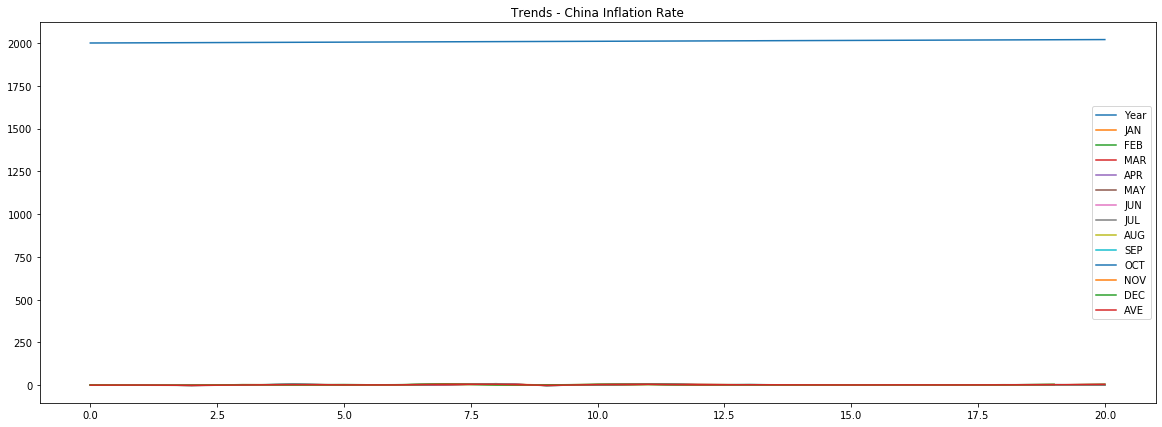

In [38]:
# Plotting the China Yearly Imports trends.
cn_inflation_rate_df.plot(title='Trends - China Inflation Rate', figsize=(20,7))

In [39]:
# Read in USA Monthly inflation rates and sort by month
us_inflation_rate_df = pd.read_csv(Path("../Resources/us_inflation_rate.csv")).sort_index()
#Renaming the Year column
us_inflation_rate_df.columns.values[0] = "Year"
us_inflation_rate_df.tail()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AVE
102,2016,1.4,1.0,0.9,1.1,1.0,1.0,0.8,1.1,1.5,1.6,1.7,2.1,1.3
103,2017,2.5,2.7,2.4,2.2,1.9,1.6,1.7,1.9,2.2,2.0,2.2,2.1,2.1
104,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9,2.4
105,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3,1.8
106,2020,2.5,2.3,1.5,0.3,0.1,0.6,1.0,1.3,1.4,1.2,NaN,NaN,NaN


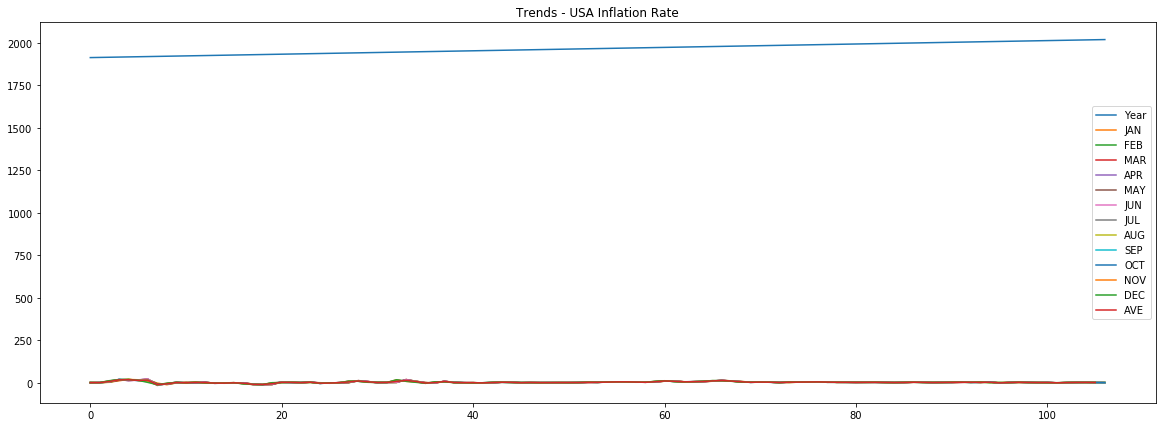

In [40]:
# Plotting the USA Yearly Imports trends.
us_inflation_rate_df.plot(title='Trends - USA Inflation Rate', figsize=(20,7))

In [41]:
# Read in final big data

## Combine 
combined_portfolios_df_extra = pd.concat(
    [china_imports_df,cn_inflation_rate_df, us_inflation_rate_df], axis="columns", join="inner"
)
combined_portfolios_df_extra
combined_portfolios_df_extra.tail()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,...,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AVE
16,2016,205333.33,205333.33,205333.33,205333.33,205333.33,205333.33,205333.33,205333.33,205333.33,...,0.6,-0.6,-1.8,-4.0,-4.6,-4.0,-4.6,-5.2,-6.4,-2.3
17,2017,288000.00,288000.00,288000.00,288000.00,288000.00,288000.00,288000.00,288000.00,288000.00,...,-8.8,-9.5,-10.1,-9.0,-8.5,-9.6,-9.7,-10.4,-9.3,-9.0
18,2018,373583.33,373583.33,373583.33,373583.33,373583.33,373583.33,373583.33,373583.33,373583.33,...,-10.3,-10.5,-9.9,-9.9,-10.6,-10.7,-10.7,-10.2,-10.3,-9.9
19,2019,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,...,-9.4,-8.0,-6.6,-3.7,-2.2,-1.5,-0.8,0.0,0.8,-5.1
20,2020,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,583333.33,...,5.6,5.6,5.5,2.3,1.5,3.0,2.3,2.3,1.5,3.1


In [42]:
# datelist = pd.date_range(start_date, end_date + pd.Timedelta('1d'), freq='1d').tolist()
# for date in datelist:
#     print(date.strftime('%Y-%m-%d'))

# try = pd.merge(datelist, china_imports_df1, left_index=True, right_index=True)
# try = dict(zip(datelist,china_imports_df1))

# china_imports_df1 = np.array(china_imports_df["D_Avg_imports"])
# np.tile(china_imports_df1,(365,1))
# china_imports_df1

In [43]:
# pd.cn_inflation_rate_df.T

In [44]:
# import requests
# url = "http://api.marketstack.com/v1/eod?access_key=0f9ee0f3fb814f44c980458b3660d8ff&symbols=EURUSD&sort=DESC&date_from=2000-01-01&date_to=2020-11-19&limit=100&offset=0"
# response = requests.get(url)
# response.text

In [45]:
# df = investpy.get_stock_historical_data(stock='DXY',
#                                         country='United States',
#                                         from_date='01/01/2010',
#                                         to_date='01/01/2020')
# print(df.head())

# stocks_df = investpy.get_stocks(country=None)
# stocks_df.to_csv("../stocks_df.csv")
# stocks_df.tail()

# indices_df = investpy.get_indices(country=None)
# indices_df.to_csv("../indices_df.csv")
# indices_df.tail()

# commodities_df = investpy.get_commodities()
# commodities_df.to_csv("../commodities_df.csv")
# commodities_df.tail()

# currencies_df = investpy.get_currencies()
# currencies_df.to_csv("../currencies_df.csv")
# currencies_df.tail()